# **Import Library**

In [2]:
from nltk.corpus import stopwords # Daftar kata-kata berhenti dalam teks
from nltk.stem import PorterStemmer # Stemmer yang digunakan adalah Porter Stemmer.
from nltk.tokenize import word_tokenize # Tokenisasi teks
from sklearn.feature_extraction.text import TfidfVectorizer # Konversi teks menjadi vektor TF-IDF
from sklearn.linear_model import LogisticRegression # Algoritma Logistic Regression untuk klasifikasi
from sklearn.metrics import accuracy_score # Metrik akurasi
from sklearn.model_selection import train_test_split # Membagi data menjadi set pelatihan dan pengujian
from tensorflow.keras.callbacks import EarlyStopping # Menghentikan pelatihan model jika tidak ada peningkatan
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, Embedding, SpatialDropout1D # Layer yang digunakan dalam model
from tensorflow.keras.models import Sequential # Model neural network
from tensorflow.keras.preprocessing.sequence import pad_sequences # Mengisi atau memotong teks menjadi panjang yang sama
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenisasi teks
from textblob import TextBlob # Pustaka untuk pemrosesan bahasa alami
from wordcloud import WordCloud # Membuat visualisasi berbentuk awan kata (word cloud) dari teks
import matplotlib.pyplot as plt # Matplotlib untuk visualisasi data
import nltk # Import pustaka NLTK (Natural Language Toolkit).
import numpy as np # NumPy untuk komputasi numerik
import pandas as pd # Pandas untuk manipulasi dan analisis data
import re # Modul untuk bekerja dengan ekspresi reguler
import seaborn as sns # Seaborn untuk visualisasi data statistik, mengatur gaya visualisasi
import string # Berisi konstanta string, seperti tanda baca
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stop words) dalam berbagai bahasa.
np.random.seed(0) # Mengatur seed untuk reproduktibilitas
pd.options.mode.chained_assignment = None # Menonaktifkan peringatan chaining

[nltk_data] Downloading package punkt to /home/bima/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/bima/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


I0000 00:00:1726831110.439381    7473 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-20 18:18:30.440036: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# **Skema 3: Bi-LSTM + 7:3 Train-Test Split**

## Data Splitting (7:3)

In [21]:
balanced_df = pd.read_csv('balanced_reviews.csv') # Membaca data ulasan yang telah seimbang
balanced_df = balanced_df.dropna() # Menghapus baris yang mengandung nilai kosong
balanced_df.head(1) # Menampilkan lima baris pertama

,content,text_clean,text_casefoldingText,text_tokenizingText,text_stopword,text_stemmingText,text_akhir,polarity,label
0,Game is very fun and helps you learn about pla...,Game is very fun and helps you learn about pla...,game is very fun and helps you learn about pla...,"['game', 'is', 'very', 'fun', 'and', 'helps', ...","['game', 'fun', 'helps', 'learn', 'playing', '...","['game', 'fun', 'help', 'learn', 'play', 'game...",game fun help learn play game real rig opinion...,0.088889,pos


In [22]:
MAX_NB_WORDS = 50000 # Jumlah kata yang akan digunakan
MAX_SEQUENCE_LENGTH = 250 # Panjang maksimum dari setiap kalimat
EMBEDDING_DIM = 100 # Dimensi vektor embedding

In [23]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(balanced_df['text_akhir'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16446 unique tokens.


In [24]:
X = tokenizer.texts_to_sequences(balanced_df['text_akhir'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (23998, 250)


In [25]:
Y = pd.get_dummies(balanced_df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (23998, 3)


In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(16798, 250) (16798, 3)
(7200, 250) (7200, 3)


## Model Training

In [27]:
# Define the Bi-LSTM model architecture
bilstm_model = Sequential()
bilstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
bilstm_model.add(SpatialDropout1D(0.2))
bilstm_model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(Dense(3, activation='softmax'))
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/home/bima/miniconda3/envs/ai/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1726831772.926689    7473 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-20 18:29:32.926880: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [29]:
# Train the model
epochs = 10
batch_size = 64
history = bilstm_model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 118s 498ms/step - accuracy: 0.8959 - loss: 0.2794 - val_accuracy: 0.9000 - val_loss: 0.2832
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 102s 432ms/step - accuracy: 0.9301 - loss: 0.1943 - val_accuracy: 0.9042 - val_loss: 0.2689
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 332ms/step - accuracy: 0.9558 - loss: 0.1347 - val_accuracy: 0.9095 - val_loss: 0.2826
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 79s 334ms/step - accuracy: 0.9592 - loss: 0.1156 - val_accuracy: 0.9065 - val_loss: 0.2771
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 77s 326ms/step - accuracy: 0.9732 - loss: 0.0848 - val_accuracy: 0.9083 - val_loss: 0.2902


In [30]:
accuracy_train_bilstm = bilstm_model.evaluate(X_train, Y_train)
print('Bi-LSTM - accuracy_train:', accuracy_train_bilstm[1])

525/525 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.9855 - loss: 0.0488
Bi-LSTM - accuracy_train: 0.9773187041282654


In [31]:
accuracy_test_bilstm = bilstm_model.evaluate(X_test, Y_test)
print('Bi-LSTM - accuracy_test:', accuracy_test_bilstm[1])

225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9134 - loss: 0.2581
Bi-LSTM - accuracy_test: 0.9123610854148865


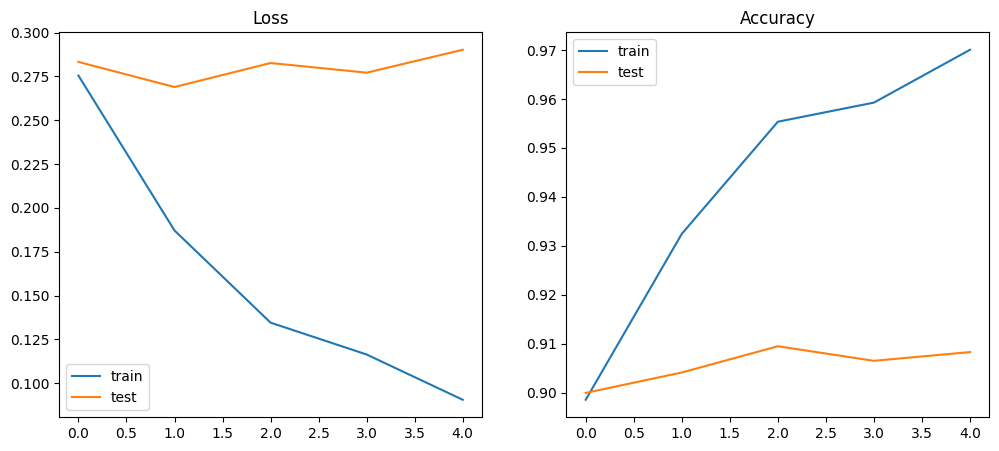

In [32]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss on the first subplot
ax1.set_title('Loss')
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()

# Plot Accuracy on the second subplot
ax2.set_title('Accuracy')
ax2.plot(history.history['accuracy'], label='train')
ax2.plot(history.history['val_accuracy'], label='test')
ax2.legend()

# Display the plots
plt.show()

## Review Prediction

In [33]:
new_review = ['''Very upsetting, I had a few million coins when the dang game started glitching, I would make a shot and the game would glitch and you could clearly see that the shot went in but the screen would flàsh and the balls would be right back like they were before I shot. And the opponent would have ball in hand. Then for some ungodly reason the game restarted and almost all of my coins were gone!!!!! There should be some way to get them back since it was the game that took them. About ready to delete!!''']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = bilstm_model.predict(padded)
labels = ['neg', 'neutral', 'pos']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
[[9.9971932e-01 1.1482449e-04 1.6584013e-04]] neg


# Inference Testing

In [35]:
# Save the trained model
bilstm_model.save('bilstm_model.keras')
print("Model saved as bilstm_model.keras")

Model saved as bilstm_model.keras


In [36]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_bilstm_model = load_model('bilstm_model.keras')
print("Model loaded from bilstm_model.keras")

Model loaded from bilstm_model.keras


/home/bima/miniconda3/envs/ai/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [37]:
loaded_bilstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 250, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,322,808 (39.38 MB)

 Trainable params: 5,161,403 (19.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,161,405 (19.69 MB)

In [39]:
import pickle

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer saved as tokenizer.pickle")

Tokenizer saved as tokenizer.pickle


In [40]:
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

print("Tokenizer loaded from tokenizer.pickle")

Tokenizer loaded from tokenizer.pickle


In [43]:
# Inference testing using loaded_bilstm_model
test_review = ['''The game is quite enjoyable but has some bugs that need fixing. Sometimes it crashes unexpectedly, which is frustrating. However, the gameplay is smooth and the graphics are impressive.''']
test_seq = loaded_tokenizer.texts_to_sequences(test_review)
test_padded = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)
test_pred = loaded_bilstm_model.predict(test_padded)
labels = ['Negative', 'Neutral', 'Positive']
print(test_pred, labels[np.argmax(test_pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[[9.9933583e-01 2.7329556e-04 3.9087160e-04]] Negative
